# Alanine Dipeptide Example with High-Level Builder API

This tutorial improves on the basic alanine example in various ways:

1. It uses neural spline transforms, which are much more expressive than affine transforms. These are implemented in the third-party package `nflows`. You need to `pip install nflows` into your conda environment in order to run this notebook.

2. It respects the domains of the ICs and the periodicity of torsions.

3. It transforms internal coordinates in a physics-informed manner. Concretely, the "slow" degrees of freedom, torsions and "fixed atoms", are generated first. Angles and bonds are conditioned on these slow degrees of freedom and added later in an autoregressive manner.

All that stuff happens under the hood of a high-level builder API.

In [1]:
import alanine_dipeptide_basics as basic
import torch
import bgflow as bg

/home/henrik/miniforge3/envs/bgflow/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of

2048it [00:00, 13174746.31it/s]         


In [2]:
# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")

## Define Boltzmann Generator

Parse the prior dimensions etc. from the coordinate transform.

In [3]:
#constrained_bonds = 

In [3]:
shape_info = bg.ShapeDictionary.from_coordinate_transform(
    basic.coordinate_transform, #n_constraints=
)
print(shape_info)

ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False, is_cartesian=False), (17,)), (TensorInfo(name='ANGLES', is_circular=False, is_cartesian=False), (17,)), (TensorInfo(name='TORSIONS', is_circular=True, is_cartesian=False), (17,)), (TensorInfo(name='FIXED', is_circular=False, is_cartesian=True), (9,))])


In [4]:
builder = bg.BoltzmannGeneratorBuilder(
    shape_info, 
    target=basic.target_energy, 
    device=basic.device, 
    dtype=basic.dtype
)

The builder class uses reasonable default choices for the transforms and conditioner networks but it's customizable. If you want to tinker with the settings, take a look at the documentation.

For example each `add_condition` call can take various keyword arguments that specify the depth and width of the conditioner network, the transformer type, etc. To change the dimension and number of hidden layers in a conditioner, try something like `builder.add_condition(TORSION, on=FIXED, hidden=(32,64,32))`.

In [5]:
from bgflow import TORSIONS, FIXED, BONDS, ANGLES

In [6]:
for i in range(4):
    builder.add_condition(TORSIONS, on=FIXED)
    builder.add_condition(FIXED, on=TORSIONS)

for i in range(2):
    builder.add_condition(BONDS, on=ANGLES)
    builder.add_condition(ANGLES, on=BONDS)
builder.add_map_to_ic_domains()
builder.add_map_to_cartesian(basic.coordinate_transform)
generator = builder.build_generator()

/home/henrik/miniforge3/envs/bgflow/lib/python3.8/site-packages/bgflow-0.3.0+19.gfbba56f-py3.8.egg/bgflow/nn/flow/transformer/spline.py:80: UserWarning: your nflows version does not support 'enable_identity_init'.See https://github.com/bayesiains/nflows/pull/65


In [7]:
# TEST
# play forward and backward
samples = generator.sample(2)
energy = generator.energy(samples)
generator.kldiv(10)

tensor([[2050308.2500],
        [ 428747.9375],
        [ 575397.8750],
        [ 406216.6875],
        [ 221212.6875],
        [ 730454.0625],
        [ 776362.2500],
        [1096000.8750],
        [ 858687.5625],
        [ 865580.5625]], device='cuda:0', grad_fn=<SubBackward0>)

## Train

In [8]:
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False
)

In [9]:
if main:
    nll_trainer.train(
        n_iter=1000, 
        data=basic.training_data,
        batchsize=128,
        n_print=100, 
        w_energy=0.0
    )

1	NLL: -13.6515	
101	NLL: -189.1053	
201	NLL: -189.9714	
301	NLL: -190.7881	
401	NLL: -190.7168	
501	NLL: -191.0468	
601	NLL: -190.7855	
701	NLL: -191.9453	
801	NLL: -192.2804	
901	NLL: -192.3651	


# Save and Load

In [11]:
#torch.save(generator.state_dict(), "saved_model.pt")

In [12]:
#generator.load_state_dict(torch.load("saved_model.pt"))

## Plot

In [10]:
from matplotlib import pyplot as plt

/home/henrik/miniforge3/envs/bgflow/lib/python3.8/site-packages/bgflow-0.3.0+19.gfbba56f-py3.8.egg/bgflow/nn/flow/crd_transform/ic_helper.py:283: UserWarning: singular division in torsion computation


Sampling Efficiency:  0.000332265452016145


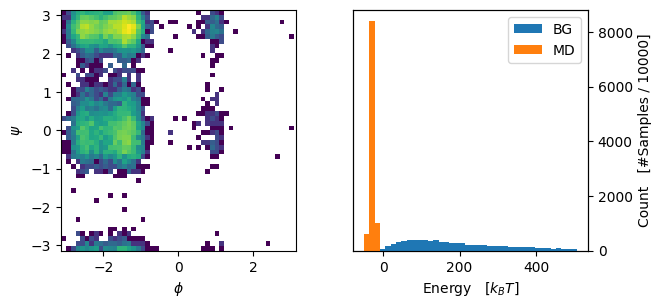

In [11]:
if main:
    
    n_samples = 10000
    samples = generator.sample(n_samples)

    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    fig.tight_layout()

    basic.plot_phi_psi(axes[0], samples, basic.system)
    basic.plot_energies(axes[1], samples, basic.target_energy, basic.test_data)

    logw = generator.log_weights(samples)
    print("Sampling Efficiency: ",  bg.sampling_efficiency(logw).item())
    del samples

In [13]:
import nglview as nv
import mdtraj as md

xyz = generator.sample(1000).detach().cpu().numpy().reshape(1000, -1, 3)
#xyz = basic.dataset.xyz[:1000]

traj = md.Trajectory(
    xyz,
    topology=basic.dataset.system.mdtraj_topology
)


ModuleNotFoundError: No module named 'nglview'

In [12]:
xyz.shape

NameError: name 'xyz' is not defined

In [13]:
nv.show_mdtraj(traj)

NGLWidget(max_frame=999)